# ML course
## Task 2
- Step by step from: https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7
- Can be improved with: https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed

Work for: https://www.machinelearningcourse.io/courses/take/make-money/texts/7951539-homework-assignment-stock-prediction

In [1]:
%%bash
# pip install pandas_datareader

In [2]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [3]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-06,118.160004,116.470001,116.779999,117.910004,31751900.0,112.973305
2017-01-09,119.430000,117.940002,117.949997,118.989998,33561900.0,114.008080
2017-01-10,119.379997,118.300003,118.769997,119.110001,24462100.0,114.123047
2017-01-11,119.930000,118.599998,118.739998,119.750000,27588600.0,114.736275
2017-01-12,119.300003,118.209999,118.900002,119.250000,27086200.0,114.257195


### Rolling Mean (Moving Average) — to determine trend

In [4]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [5]:
mavg.tail()

Date
2017-01-06    107.335924
2017-01-09    107.433354
2017-01-10    107.533458
2017-01-11    107.641030
2017-01-12    107.741141
Name: Adj Close, dtype: float64

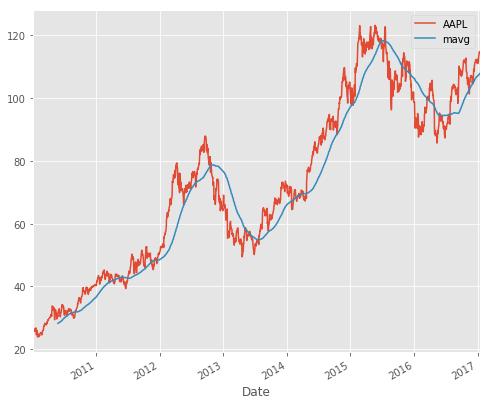

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

### Return Deviation — to determine risk and return

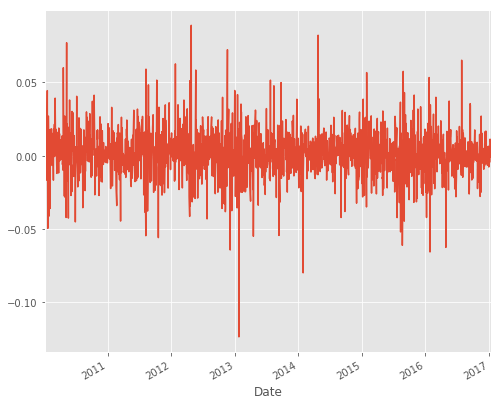

In [7]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

### Analysing your Competitors Stocks

In [8]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

### Correlation Analysis — Does one competitor affect others?

In [9]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

In [10]:
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.381475,0.411708,0.383816,0.393525
GE,0.381475,1.000000,0.422261,0.535149,0.474111
GOOG,0.411708,0.422261,1.000000,0.403004,0.472081
IBM,0.383816,0.535149,0.403004,1.000000,0.496582
MSFT,0.393525,0.474111,0.472081,0.496582,1.000000


Text(0,0.5,'Returns GE')

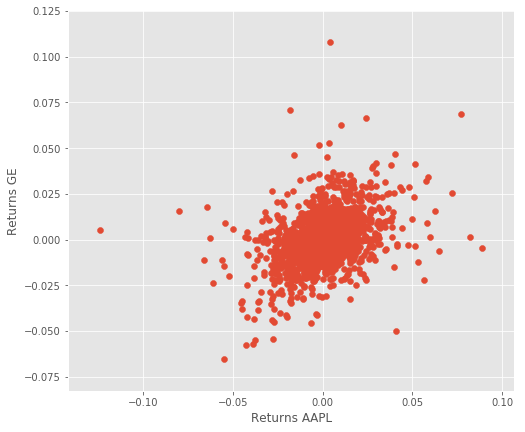

In [11]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel("Returns AAPL")
plt.ylabel("Returns GE")

/Users/rodrigobeceiro/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


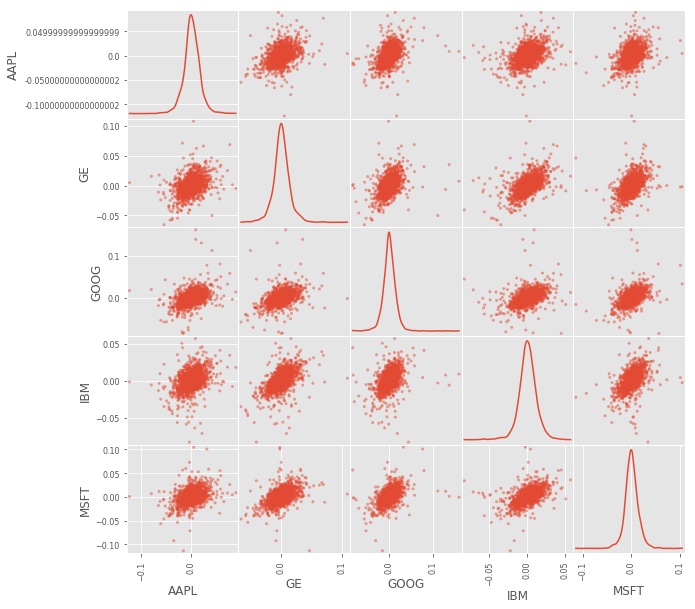

In [12]:
pd.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

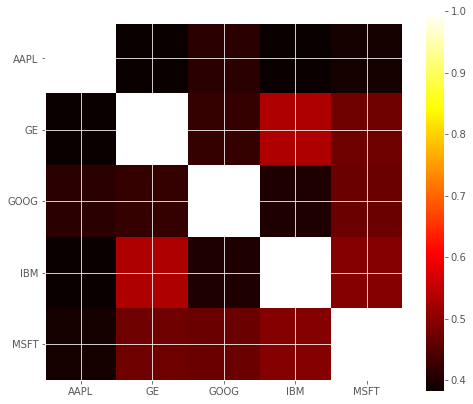

In [13]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

### Stocks Returns Rate and Risk


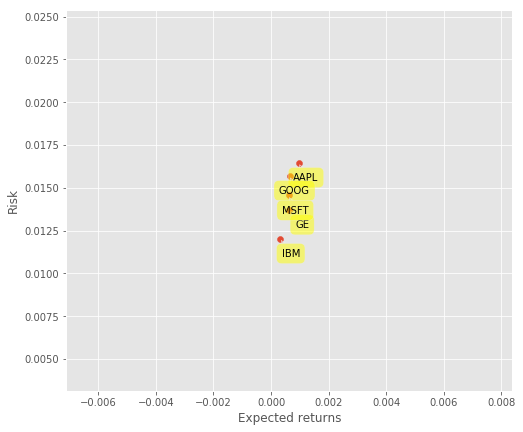

In [14]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

## Predicting Stocks Price

### Feature Engineering

In [15]:
dfreg = df.loc[:,["Adj Close","Volume"]]
dfreg["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
dfreg["PCT_change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0

In [16]:
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2017-01-06,112.973305,31751900.0,1.433299,0.967636
2017-01-09,114.008080,33561900.0,1.252204,0.881730
2017-01-10,114.123047,24462100.0,0.906720,0.286271
2017-01-11,114.736275,27588600.0,1.110649,0.850600
2017-01-12,114.257195,27086200.0,0.914049,0.294364


### Pre-processing & Cross Validation

In [17]:
import math
import numpy as np
from sklearn import preprocessing

In [18]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

/Users/rodrigobeceiro/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


### Model Generation

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [20]:
X.shape

(1752, 4)

In [21]:
y.shape

(1752,)

In [22]:
X_train = X[:1200]
y_train = y[:1200]
X_test = X[1200:]
y_test = y[1200:]

In [23]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

/Users/rodrigobeceiro/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

### K Nearest Neighbor (KNN)

In [24]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=3)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [25]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
# results
print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)

The linear regression confidence is  0.46460618936446174
The quadratic regression 2 confidence is  0.4618081674958675
The quadratic regression 3 confidence is  -0.1748262933779787
The knn regression confidence is  -2.206314546873257


### Plotting results

In [26]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan

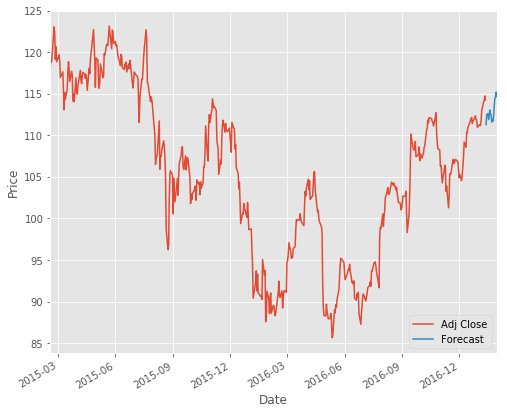

In [27]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()